In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 层和块
- 层: 表示神经网络结构中的一层, 接受上一层(或者输入数据)的输入, 并且输入数据到下一层
- 块: 表示一系列层的集合, 对于一些复杂的网络结构, 可能是由很多重复的块组成的, 比如 `ResNet152` 就是有一系列重复的块组成的
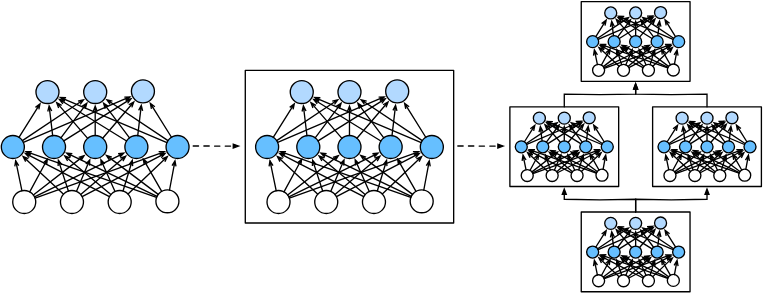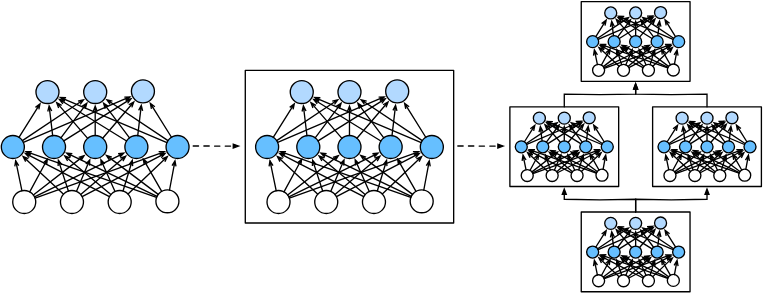

可以使用 `nn.Sequential` 函数来构建模型, 层的执行顺序通过参数传递, `nn.Sequential`定义一种特殊的 `Module`, 也就是在 `PyTorch` 中表示一个块的类, 它维护类一个由 `nn.Moudle` 组成的有序列表, 并且 `nn.Linear` 就是 `nn.Module` 的子类, 同时 `net(X)` 使用了可调用对象, 其实是调用了底层的 `__call__(X)` 方法(这一个方法应该在 `nn.Module` 中实现了

## 自定义块
继承 `nn.Module`, 同时实现构造函数 `__init__` 以及 `forward` 函数即可, 同时注意可以调用父类 `Module` 的构造函数来执行必要的初始化操作

In [13]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.out = nn.Linear(256, 10)
    def forward(self, X):
        return self.out(F.relu(self.hidden(X)))
# 实例化
net = MLP()
X = torch.arange(20.0).reshape((1, -1))
net(X)

tensor([[-0.3212,  2.1584,  2.1385,  0.7541,  1.1687, -1.9876,  0.0793,  0.9569,
         -1.0173,  2.1557]], grad_fn=<AddmmBackward0>)

## 顺序块
`nn.Sequential`可以把其他的模块(`nn.Module`)串联起来, 实现原理如下:

In [19]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            self._modules[str(idx)] = module
    def forward(self, X):
        for block in self._modules.values():
            X = block(X)
        return X
# 注意这里使用 nn.ReLU() 相当于是 F.relu() 函数单独组成的一个 nn.Module
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.0689,  2.9217, -0.3639, -2.4221,  0.4818, -0.3820, -0.1100, -0.2478,
         -3.5343, -0.3509]], grad_fn=<AddmmBackward0>)

注意到这里的 `self._modules` 本来就是内置的一个属性, 这里不需要自己定以一个 `Python` 列表, 优点就是在模型参数初始化过程中, 系统该可以在 `_modules` 字典中查找需要初始化参数的子块

## 在前向传播中执行代码
利用 `nn.Module` 可以使得网络结果更加灵活, 可以在 `forward` 函数中执行各种需要的操作 

In [20]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)
    def forward(self, X):
        return self.linear(self.net(X))
chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20))